In [1]:
"""
From RGB to YCbCr
"""

def RGB_to_YCbCr(COLOR_IMG):
    """    
    Y = 0.299 R + 0.587 G + 0.114 B
    Cb = - 0.1687 R - 0.3313 G + 0.5 B + 128
    Cr = 0.5 R - 0.4187 G - 0.0813 B + 128
    """
    
    W, H, C = COLOR_IMG.shape
    YCbCr_IMG = np.zeros((W, H, C))
    
    for w in range(W):
        for h in range(H):
            YCbCr_IMG[w,h,0] = + 0.2990*COLOR_IMG[w,h,0] + 0.5870*COLOR_IMG[w,h,1] + 0.1140*COLOR_IMG[w,h,2] +   0
            YCbCr_IMG[w,h,1] = - 0.1687*COLOR_IMG[w,h,0] - 0.3313*COLOR_IMG[w,h,1] + 0.5000*COLOR_IMG[w,h,2] + 128
            YCbCr_IMG[w,h,2] = + 0.5000*COLOR_IMG[w,h,0] - 0.4187*COLOR_IMG[w,h,1] - 0.0813*COLOR_IMG[w,h,2] + 128
    
    return YCbCr_IMG

In [2]:
"""
From YCbCr to RGB
"""
def YCbCr_to_RGB(YCbCr_IMG):
    """
    R = Y + 1.402 (Cr-128)
    G = Y - 0.34414 (Cb-128) - 0.71414 (Cr-128)
    B = Y + 1.772 (Cb-128)
    """
    
    W, H, C = YCbCr_IMG.shape
    COLOR_IMG = np.zeros((W, H, C), np.uint8) # Avoid floating points
    
    for w in range(W):
        for h in range(H):
            COLOR_IMG[w,h,0] = YCbCr_IMG[w,h,0] + 1.40200*(YCbCr_IMG[w,h,2]-128)
            COLOR_IMG[w,h,1] = YCbCr_IMG[w,h,0] - 0.34414*(YCbCr_IMG[w,h,1]-128) - 0.71414*(YCbCr_IMG[w,h,2]-128)
            COLOR_IMG[w,h,2] = YCbCr_IMG[w,h,0] + 1.77200*(YCbCr_IMG[w,h,1]-128)
            
    return COLOR_IMG

In [3]:
"""
Downsample YCbCr and split them into 3 parts
"""

def Downsample_YCbCr(YCbCr_IMG):
    """
    Y  ==> Remain the same
    Cb ==> Cut down 50%
    Cr ==> Cut down 50%
    """
    W, H, C = YCbCr_IMG.shape
    CW = W//2
    CH = H//2
    Y_Channel = YCbCr_IMG[:,:,0]
    Cb_Channel= np.zeros((CW, CH))
    Cr_Channel= np.zeros((CW, CH))
    
    # In a 2x2 grid, directly use the top-left pixel
    for w in range(CW):
        for h in range(CH):
            Cb_Channel[w,h]=YCbCr_IMG[2*w,2*h,1]
            Cr_Channel[w,h]=YCbCr_IMG[2*w,2*h,2]
    
    return Y_Channel, Cb_Channel, Cr_Channel


In [4]:
"""
Upsample YCbCr the result from Inverse Consine Transform
"""
def Upsample_YCbCr(RE_Y_Channel, RE_Cb_Channel, RE_Cr_Channel, H, W):
    
    Upsample_YCbCr = np.zeros((H, W, 3))
    
    RE_CB_Channel_RS = cv.resize(RE_Cb_Channel, (H,W))
    RE_CR_Channel_RS = cv.resize(RE_Cr_Channel, (H,W))
    Upsample_YCbCr[:, :, 0] = RE_Y_Channel
    Upsample_YCbCr[:, :, 1] = RE_CB_Channel_RS
    Upsample_YCbCr[:, :, 2] = RE_CR_Channel_RS
    return Upsample_YCbCr

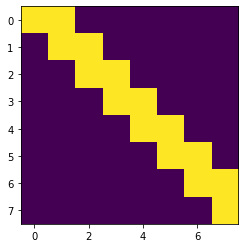

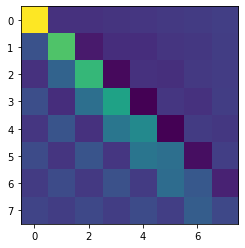

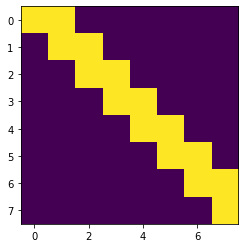

In [5]:
'''
This class is used to perform DCT and IDCT
REF: https://github.com/AbraaoHonorio/DCT-Discrete-Cosine-Transform
'''
import numpy as np
import matplotlib.pyplot as plt
from math import cos, pi, sqrt
class Github_Cosine_Transform():
    
    def __init__(self):
        pass

    def dct_2d(self, image, numberCoefficients=0):

        nc = numberCoefficients # passando para NC para melhorar a visibilidade da formula
        height = image.shape[0]
        width = image.shape[1]
        imageRow = np.zeros_like(image).astype(float)
        imageCol = np.zeros_like(image).astype(float)

        for h in range(height):
            imageRow[h, :] = self.dct_1d(image[h, :], nc) # aplicando IDCT na linhas
        for w in range(width):
            imageCol[:, w] = self.dct_1d(imageRow[:, w], nc) # aplicando IDCT nas colunas

        return imageCol

    def dct_1d(self, image, numberCoefficients=0):

        nc = numberCoefficients
        n = len(image)
        newImage= np.zeros_like(image).astype(float)


        for k in range(n):
            sum = 0
            for i in range(n):
                sum += image[i] * cos(2 * pi * k / (2.0 * n) * i + (k * pi) / (2.0 * n))
            ck = sqrt(0.5) if k == 0 else 1
            newImage[k] = sqrt(2.0 / n) * ck * sum

        # salvando os N maiores numeros e zerandos todos os outros
        if nc > 0:
            newImage.sort()
            for i in range(nc, n):
                newImage[i] = 0

        return newImage # retorno de um VETOR


    def idct_2d(self, image):
        height = image.shape[0]
        width =  image.shape[1]
        imageRow = np.zeros_like(image).astype(float)
        imageCol = np.zeros_like(image).astype(float)


        for h in range(height):
            imageRow[h, :] = self.idct_1d(image[h, :]) # aplicando IDCT na linhas
        for w in range(width):
            imageCol[:, w] = self.idct_1d(imageRow[:, w]) # aplicando IDCT nas colunas

        return imageCol

    def idct_1d(self, image):

        n = len(image)
        newImage = np.zeros_like(image).astype(float)

        for i in range(n):
            sum = 0
            for k in range(n):
                ck = sqrt(0.5) if k == 0 else 1 # operador tenario para verificar o valor do CK
                sum += ck * image[k] * cos(2 * pi * k / (2.0 * n) * i + (k * pi) / (2.0 * n))

            newImage[i] = sqrt(2.0 / n) * sum

        return newImage
    
"""
link:http://www.robertstocker.co.uk/jpeg/jpeg_new_9.htm

Thanks to Teacher's link, I re-implemented the demo 8x8 block
in order to test whether my DCT methods is okay or not.
"""
TEST_BLOCK_01 = np.array([[  5, 5, 64, 64, 5, 5, 5, 5 ],
                          [  5, 5, 64, 64, 5, 5, 5, 5 ],
                          [  5, 5, 64, 64, 5, 5, 5, 5 ],
                          [  5, 5, 64, 64, 5, 5, 5, 5 ],
                          [  5, 5, 64, 64, 5, 5, 5, 5 ],
                          [  5, 5, 64, 64, 5, 5, 5, 5 ],
                          [  5, 5, 64, 64, 5, 5, 5, 5 ],
                          [  5, 5, 64, 64, 5, 5, 5, 5 ],])

TEST_BLOCK_02 = np.array([[  5,  5,  5,  5,  5,  5,  5,  5 ],
                          [  5,  5,  5,  5,  5,  5,  5,  5 ],
                          [ 64, 64, 64, 64, 64, 64, 64, 64 ],
                          [ 64, 64, 64, 64, 64, 64, 64, 64 ],
                          [  5,  5,  5,  5,  5,  5,  5,  5 ],
                          [  5,  5,  5,  5,  5,  5,  5,  5 ],
                          [  5,  5,  5,  5,  5,  5,  5,  5 ],
                          [  5,  5,  5,  5,  5,  5,  5,  5 ],])

TEST_BLOCK_03 = np.array([[ 64, 64,  5,  5,  5,  5,  5,  5 ],
                          [  5, 64, 64,  5,  5,  5,  5,  5 ],
                          [  5,  5, 64, 64,  5,  5,  5,  5 ],
                          [  5,  5,  5, 64, 64,  5,  5,  5 ],
                          [  5,  5,  5,  5, 64, 64,  5,  5 ],
                          [  5,  5,  5,  5,  5, 64, 64,  5 ],
                          [  5,  5,  5,  5,  5,  5, 64, 64 ],
                          [  5,  5,  5,  5,  5,  5,  5, 64 ],])

# Step 1: Choose Test Block
TEST_BLOCK = TEST_BLOCK_03
plt.imshow(TEST_BLOCK)
plt.show()

# Step 2: Perform DCT on Test Block
DCT_Tool = Github_Cosine_Transform()
DCT_BLOCK = DCT_Tool.dct_2d(TEST_BLOCK)
plt.imshow(DCT_BLOCK)
plt.show()

# Step 3: (Optional) Inverse DCT
INV_DCT_BLOCK = DCT_Tool.idct_2d(DCT_BLOCK)
plt.imshow(INV_DCT_BLOCK)
plt.show()

In [6]:
"""
Perform De-Quantization on a single 8x8 block
"""

def RE_Quantization(Block_Qtzd, MODE):
    if MODE == "Y":

        QT_Y = np.array([[  2,  1,  1,  1,  1,  1,  2,  1 ],
                         [  1,  1,  2,  2,  2,  2,  2,  4 ],
                         [  3,  2,  2,  2,  2,  5,  4,  4 ],
                         [  3,  4,  6,  5,  6,  6,  6,  5 ],
                         [  6,  6,  6,  7,  9,  8,  6,  7 ],
                         [  9,  7,  6,  6,  8, 11,  8,  9 ],
                         [ 10, 10, 10, 10, 10,  6,  8, 11 ],
                         [ 12, 11, 10, 12,  9, 10, 10, 10 ],])
#         QT_Y = np.array([[  1,  1,  1,  1,  1,  1,  1, 1 ],
#                          [  1,  1,  1,  1,  1,  1,  1, 1 ],
#                          [  1,  1,  1,  1,  1,  1,  1, 1 ],
#                          [  1,  1,  1,  1,  1,  1,  1, 1 ],
#                          [  1,  1,  1,  1,  1,  1,  1, 1 ],
#                          [  1,  1,  1,  1,  1,  1,  1, 1 ],
#                          [  1,  1,  1,  1,  1,  1,  1, 1 ],
#                          [  1,  1,  1,  1,  1,  1,  1, 1 ],])
        
        Block = np.zeros((8,8))
        Block_Y = Block_Qtzd * QT_Y
        
        return Block_Y
    
    elif MODE == "Cb" or MODE == "Cr":
        
        QT_C = np.array([[  2,  2,  2,  2,  2,  2,  5,  3 ],
                         [  3,  5, 10,  7,  6,  7, 10, 10 ],
                         [ 10, 10, 10, 10, 10, 10, 10, 10 ],
                         [ 10, 10, 10, 10, 10, 10, 10, 10 ],
                         [ 10, 10, 10, 10, 10, 10, 10, 10 ],
                         [ 10, 10, 10, 10, 10, 10, 10, 10 ],
                         [ 10, 10, 10, 10, 10, 10, 10, 10 ],
                         [ 10, 10, 10, 10, 10, 10, 10, 10 ],])
#         QT_C = np.array([[  1,  1,  1,  1,  1,  1,  1, 1 ],
#                          [  1,  1,  1,  1,  1,  1,  1, 1 ],
#                          [  1,  1,  1,  1,  1,  1,  1, 1 ],
#                          [  1,  1,  1,  1,  1,  1,  1, 1 ],
#                          [  1,  1,  1,  1,  1,  1,  1, 1 ],
#                          [  1,  1,  1,  1,  1,  1,  1, 1 ],
#                          [  1,  1,  1,  1,  1,  1,  1, 1 ],
#                          [  1,  1,  1,  1,  1,  1,  1, 1 ],])
        Block = np.zeros((8,8))
        Block_C = Block_Qtzd* QT_C
    
        return Block_C
    
    else:
        print("QAQ")

In [7]:
"""
Perform Zigzag on a 8x8 Quantized Result
"""

def ZigzagScan(Block):
    
    order_matrix = np.array([[  0,  1,  5,  6, 14, 15, 27, 28 ],
                             [  2,  4,  7, 13, 16, 26, 29, 42 ],
                             [  3,  8, 12, 17, 25, 30, 41, 43 ],
                             [  9, 11, 18, 24, 31, 40, 44, 53 ],
                             [ 10, 19, 23, 32, 39, 45, 52, 54 ],
                             [ 20, 22, 33, 38, 46, 51, 55, 60 ],
                             [ 21, 34, 37, 47, 50, 56, 59, 61 ],
                             [ 35, 36, 48, 49, 57, 58, 62, 63 ],])
    
    zigzag_out = list()
    for num in range(64):
        for x in range(8):
            for y in range(8):
                if order_matrix[x,y] == num:
                    zigzag_out.append(Block[x,y])
    
    return zigzag_out

In [8]:
"""
Reverse
Perform Reverse Zigzag on a zigzag list to get a 8x8 Quantized Result
"""

def RE_ZigzagScan(zigzag_list):
    
    order_matrix = np.array([[  0,  1,  5,  6, 14, 15, 27, 28 ],
                             [  2,  4,  7, 13, 16, 26, 29, 42 ],
                             [  3,  8, 12, 17, 25, 30, 41, 43 ],
                             [  9, 11, 18, 24, 31, 40, 44, 53 ],
                             [ 10, 19, 23, 32, 39, 45, 52, 54 ],
                             [ 20, 22, 33, 38, 46, 51, 55, 60 ],
                             [ 21, 34, 37, 47, 50, 56, 59, 61 ],
                             [ 35, 36, 48, 49, 57, 58, 62, 63 ],])
    
    block = np.zeros((8,8))
    for num in range(64):     
        for x in range(8):
            for y in range(8):
                if order_matrix[x,y] == num:
                    block[x,y] = zigzag_list[num]
    
    return block

In [31]:
"""
Perform Quantization on a single 8x8 block
"""

def Quantization(Block, MODE):
    """
    This is the point at which I can control the quality.
    I decided to follow Nikon Camera's setting
    """
    
    if MODE == "Y":

        QT_Y = np.array([[  2,  1,  1,  1,  1,  1,  2,  1 ],
                         [  1,  1,  2,  2,  2,  2,  2,  4 ],
                         [  3,  2,  2,  2,  2,  5,  4,  4 ],
                         [  3,  4,  6,  5,  6,  6,  6,  5 ],
                         [  6,  6,  6,  7,  9,  8,  6,  7 ],
                         [  9,  7,  6,  6,  8, 11,  8,  9 ],
                         [ 10, 10, 10, 10, 10,  6,  8, 11 ],
                         [ 12, 11, 10, 12,  9, 10, 10, 10 ],])
        
        Block_Y_Qtzd = np.zeros((8,8))
        Block_Y_Qtzd = Block / QT_Y
        
        #return Block_Y_Qtzd.astype(np.int8)
        return Block_Y_Qtzd.astype(np.int32)
    
    elif MODE == "Cb" or MODE == "Cr":
        
        QT_C = np.array([[  2,  2,  2,  2,  2,  2,  5,  3 ],
                         [  3,  5, 10,  7,  6,  7, 10, 10 ],
                         [ 10, 10, 10, 10, 10, 10, 10, 10 ],
                         [ 10, 10, 10, 10, 10, 10, 10, 10 ],
                         [ 10, 10, 10, 10, 10, 10, 10, 10 ],
                         [ 10, 10, 10, 10, 10, 10, 10, 10 ],
                         [ 10, 10, 10, 10, 10, 10, 10, 10 ],
                         [ 10, 10, 10, 10, 10, 10, 10, 10 ],])

        Block_C_Qtzd= np.zeros((8,8))
        Block_C_Qtzd= Block/ QT_C
    
        #return Block_C_Qtzd.astype(np.int8) this line makes things wrong
        return Block_C_Qtzd.astype(np.int32)
    
    else:
        print("QAQ")

In [32]:
"""
Perform Zero Run Length Coding on zigzagged AC result
"""

def Zero_Run_Length_Coding(zigzag_list):
    
    DC = zigzag_list[0]
    
    AC_code = list()
    count = 0
    
    for i in range(1, len(zigzag_list)):
        
        val = zigzag_list[i]
        
        if val == 0:
            count=count+1
            if i == len(zigzag_list)-1:
                assigned_tuple = (0, val)
                AC_code.append((0, val))
        else:
            assigned_tuple = (count, val)
            count = 0
        
            if i == len(zigzag_list) - 1:
                assigned_tuple = (0, 0)

            AC_code.append(assigned_tuple)

    return DC, AC_code

In [33]:
"""
Perform Reverse Zero Run Length Coding on zigzagged AC result
"""

def RE_Zero_Run_Length_Coding(DC, AC_code):
   
    tmp_RE_zigzag_list = [DC]
    
    for AC_Tuple in AC_code:
        left_number = AC_Tuple[0]
        right_number = AC_Tuple[1]
        
        for _ in range(left_number):
            tmp_RE_zigzag_list.append(0)
        tmp_RE_zigzag_list.append(right_number)
        
    while (len(tmp_RE_zigzag_list) < 64):
        tmp_RE_zigzag_list.append(0)
        
    return tmp_RE_zigzag_list

In [34]:
"""
Perform Differential Coding for DC Part
"""

def Differential_Coding(DC_Y_LIST):
    DC_Differential_LIST = []
    DC_00 = 0
    for idx, DC in enumerate(DC_Y_LIST):
        if idx == 0:
            DC_Differential_LIST.append(DC_Y_LIST[0])
        else:
            DC_BEF = DC_Y_LIST[idx-1]
            DC_NOW = DC_Y_LIST[idx]
            DC_diff = DC_NOW - DC_BEF
            DC_Differential_LIST.append(DC_diff)
    return DC_Differential_LIST

In [35]:
"""
Reverse Bit Stream to DC Part
"""

def RE_Differential_Coding(RE_DC_Differential_LIST):
    RE_DC_Y_LIST = []
    
    for idx, DC in enumerate(RE_DC_Differential_LIST):
        if idx == 0:
            RE_DC_Y_LIST.append(RE_DC_Differential_LIST[0])
        else:
            DC_BEF = RE_DC_Y_LIST[idx-1]
            DC_diff = RE_DC_Differential_LIST[idx]
            DC_NOW = DC_BEF + DC_diff
            RE_DC_Y_LIST.append(DC_NOW)
    return RE_DC_Y_LIST

In [36]:
"""
Forward
This block is related to AC Code
"""
def NESTED_LIST_to_1D_LIST(AC_code_LIST):
    AC_Tuple_LIST = []
    for AC_block in AC_code_LIST:
        for AC_tuple in AC_block:
            AC_Tuple_LIST.append((AC_tuple[0], AC_tuple[1]))
    return AC_Tuple_LIST

In [37]:
"""
Reverse
This block is related to AC Code
"""

def OneD_LIST_to_NESTED_LIST(AC_Tuple_LIST):
    AC_code_LIST = []
    idx_list = []

    for idx, AC_tuple in enumerate(AC_Tuple_LIST):
        if AC_tuple == (0, 0):
            idx_list.append(idx)

    for i, idx in enumerate(idx_list):
        tmp_block = []
        if i == 0:
            for j in range(0,idx+1):
                tmp_block.append(AC_Tuple_LIST[j])
        else:
            idx_before = idx_list[i-1]
            idx_after  = idx_list[i]
            for j in range(idx_before+1, idx_after+1):
                tmp_block.append(AC_Tuple_LIST[j])    
        AC_code_LIST.append(tmp_block)    
    return AC_code_LIST

In [38]:
"""
I implemented basically all the code the following YouTube video covered.
With a bit modification, it can be applied on DC part of this JPEG project.
https://github.com/bhrigu123/huffman-coding
"""

import os
import heapq

class HuffmanCoding:
    
    def __init__(self):
        self.heap = []
        self.codes = {}
        self.reverse_mapping = {}
    
    class HeapNode:
        def __init__(self, char, freq):
            self.char = char
            self.freq = freq
            self.left = None
            self.right= None
            
        def __lt__(self, other):
            return self.freq < other.freq
        
        def __eq__(self, other):
            if (other == None):
                return False
            if (not isinstance(other, HeapNode)):
                return False
            return self.freq == other.freq
        
    def make_frequency_dict(self, text):
        # calc freq and return
        frequency = {}
        for character in text:
            if not character in frequency:
                frequency[character] = 0
            frequency[character] += 1
        return frequency
        
    def make_heap(self, frequency):
        # make priority queue
        for key in frequency:
            node = self.HeapNode(key, frequency[key])
            heapq.heappush(self.heap, node)
        
    def merge_codes(self):
        # build huffman tree. Save root node in heap
        while(len(self.heap)>1):
            node1 = heapq.heappop(self.heap)
            node2 = heapq.heappop(self.heap)
            
            merged = self.HeapNode(None, node1.freq + node2.freq)
            merged.left = node1
            merged.right = node2
            
            heapq.heappush(self.heap, merged)
        
    def make_codes_helper(self, node, current_code):
        if(node == None):
            return
        if(node.char != None):
            self.codes[node.char] = current_code
            self.reverse_mapping[current_code] = node.char
        
        self.make_codes_helper(node.left, current_code + "0")
        self.make_codes_helper(node.right, current_code + "1")
        
    def make_codes(self):
        # make codes for characters and save
        root = heapq.heappop(self.heap)
        current_code = ""
        self.make_codes_helper(root, current_code)
    
    def get_encoded_text(self, text):
        # replace character with code and return
        encoded_text = ""
        for character in text:
            encoded_text += self.codes[character]
        return encoded_text
        
    def pad_encoded_text(self, encoded_text):
        # pad encoded text and return
        extra_padding = 8 - len(encoded_text) % 8
        for i in range(extra_padding):
            encoded_text += "0"
        
        padded_info = "{0:08b}".format(extra_padding)
        encoded_text = padded_info + encoded_text
        return encoded_text
    
    def get_byte_array(self, padded_encoded_text):
        # convert bits into bytes. Return byte array
        b = bytearray()
        for i in range(0, len(padded_encoded_text), 8):
            
            byte = padded_encoded_text[i:i+8]
            b.append(int(byte, 2))
            
        return b
    
    def DC_Compress(self, test_list, output_path):
            
        text = test_list

        frequency = self.make_frequency_dict(text)

        self.make_heap(frequency)
        self.merge_codes()
        self.make_codes()

        encoded_text = self.get_encoded_text(text)
        padded_encoded_text = self.pad_encoded_text(encoded_text)
        
        b = self.get_byte_array(padded_encoded_text)
        with open(output_path, 'wb') as output:
            output.write(bytes(b))

        return 1
    
    # =====================================
    
    def remove_padding(self, bit_string):
        # remove padding and return
        padded_info = bit_string[:8]
        extra_padding = int(padded_info, 2)
        
        bit_string = bit_string[8:]
        encoded_text = bit_string[:-1*extra_padding]
        
        return encoded_text
    
    def decode_text(self, encoded_text):
        # decode and return
        current_code = ""
        decoded_text = []
        for bit in encoded_text:
            current_code += bit
            if (current_code in self.reverse_mapping):
                character = self.reverse_mapping[current_code]
                decoded_text.append(character) 
                current_code = ""
        
        return decoded_text
    
    def DC_Decompress(self, input_path):

        with open(input_path, 'rb') as file:
            bit_string=""
            
            byte = file.read(1)

            while(len(byte) > 0):
                byte = ord(byte)
                bits = bin(byte)[2:].rjust(8, '0')
                bit_string += bits
                byte = file.read(1)

        encoded_text = self.remove_padding(bit_string)
        decoded_text = self.decode_text(encoded_text)
            
        return decoded_text

In [39]:
import matplotlib.pyplot as plt
from math import cos,sqrt,pi
from tqdm import tqdm
import numpy as np
import cv2 as cv
import os

# This command will output the existing images
BASE_DIR = "../Data/Hw4/standard_test_images/"
#print(os.listdir(BASE_DIR))

GRAY_IMG_LIST = ["cameraman.tif", 
                 "house.tif", 
                 "jetplane.tif",
                 "lake.tif", 
                 "lena_gray_256.tif", 
                 "lena_gray_512.tif", 
                 "livingroom.tif", 
                 "mandril_gray.tif", 
                 "peppers_gray.tif", 
                 "pirate.tif", 
                 "walkbridge.tif", 
                 "woman_blonde.tif", 
                 "woman_darkhair.tif"]

COLOR_IMG_LIST = ["lena_color_256.tif", "lena_color_512.tif", "mandril_color.tif", "peppers_color.tif"]

In [40]:
# Read Image
COLOR_IMG = COLOR_IMG_LIST[1]
COLOR_IMG = cv.imread(BASE_DIR+COLOR_IMG)
COLOR_IMG = cv.cvtColor(COLOR_IMG, cv.COLOR_BGR2RGB)
W, H, C = COLOR_IMG.shape

# RGB to YCbCr
YCbCr_IMG = RGB_to_YCbCr(COLOR_IMG)

# Downsample YCbCr
Y_Channel, Cb_Channel, Cr_Channel = Downsample_YCbCr(YCbCr_IMG)

In [41]:
# For Each 8x8 Block Do Following things

# Y Channel

DC_Y_LIST = []
AC_code_Y_LIST = []

for w in tqdm(range(0,W,8)):
    for h in range(0,H,8):
        
        # (0) Get 8x8 Grid
        TILE_Y = Y_Channel[w:w+8,h:h+8]
        
        # (1) DCT
        DCT_Y = DCT_Tool.dct_2d(TILE_Y)
        
        # (2) Quantization
        QTZ_Y = Quantization(DCT_Y, MODE="Y")
        
        # (3) Zig-zag Scan
        ZZS_Y = ZigzagScan(QTZ_Y)
        
        # (4) Zero Run Length Coding
        DC_Y, AC_code_Y = Zero_Run_Length_Coding(ZZS_Y)
        
        # (5) Prepare For Huffman Encoding
        DC_Y_LIST.append(DC_Y)
        AC_code_Y_LIST.append(AC_code_Y)
        
#         print(TILE_Y)
#         print(DCT_Y)
#         print(QTZ_Y)
#         print(type(ZZS_Y))
#         print(type(DC_Y))
#         print(type(AC_code_Y))
#         print(type(DC_Y_LIST))
#         print(type(AC_code_Y_LIST))
#         break
#     break
        

# Perform Differential Coding


# Cb & Cr Channel

DC_Cb_LIST = []
DC_Cr_LIST = []
AC_code_Cb_LIST = []
AC_code_Cr_LIST = []
        
for w in tqdm(range(0, W//2, 8)):
    for h in range(0, H//2, 8):
        
        # (0) Get 8x8 Grid
        TILE_Cb = Cb_Channel[w:w+8,h:h+8]
        TILE_Cr = Cr_Channel[w:w+8,h:h+8]
        
        # (1) DCT
        DCT_Cb = DCT_Tool.dct_2d(TILE_Cb)
        DCT_Cr = DCT_Tool.dct_2d(TILE_Cr)
        
        # (2) Quantization
        QTZ_Cb = Quantization(DCT_Cb, MODE="Cb")
        QTZ_Cr = Quantization(DCT_Cr, MODE="Cr")
        
        # (3) Zig-zag Scan
        ZZS_Cb = ZigzagScan(QTZ_Cb)
        ZZS_Cr = ZigzagScan(QTZ_Cr)
        
        # (4) Zero Run Length Coding
        DC_Cb, AC_code_Cb = Zero_Run_Length_Coding(ZZS_Cb)
        DC_Cr, AC_code_Cr = Zero_Run_Length_Coding(ZZS_Cr)
        
        # (5) Prepare For Huffman Encoding
        DC_Cb_LIST.append(DC_Cb)
        DC_Cr_LIST.append(DC_Cr)
        AC_code_Cb_LIST.append(AC_code_Cb)        
        AC_code_Cr_LIST.append(AC_code_Cr)

#         print(DC_Cb)
#         break
#     break


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:04<00:00,  7.68it/s]


In [42]:
# Perform Differential Coding
DC_Differential_Y_LIST = Differential_Coding(DC_Y_LIST)
DC_Differential_Cb_LIST = Differential_Coding(DC_Cb_LIST)
DC_Differential_Cr_LIST = Differential_Coding(DC_Cr_LIST)

# Perform Huffman Coding: Compress
Y_DC_HCoding = HuffmanCoding()
Cb_DC_HCoding = HuffmanCoding()
Cr_DC_HCoding = HuffmanCoding()

Y_DC_HCoding.DC_Compress(DC_Differential_Y_LIST, "DC_Y_b.bin")
Cb_DC_HCoding.DC_Compress(DC_Differential_Cb_LIST, "DC_Cb_b.bin")
Cr_DC_HCoding.DC_Compress(DC_Differential_Cr_LIST, "DC_Cr_b.bin")
# ------------------------------------------------------- #

# Perform Huffman De-Coding: Decompress 
RE_DC_Y_b = Y_DC_HCoding.DC_Decompress("DC_Y_b.bin")
RE_DC_Cb_b = Cb_DC_HCoding.DC_Decompress("DC_Cb_b.bin")
RE_DC_Cr_b = Cr_DC_HCoding.DC_Decompress("DC_Cr_b.bin")

# Perform Reverse Differential Coding
RE_DC_Y_LIST  = RE_Differential_Coding(RE_DC_Y_b)
RE_DC_Cb_LIST = RE_Differential_Coding(RE_DC_Cb_b)
RE_DC_Cr_LIST = RE_Differential_Coding(RE_DC_Cr_b)

In [43]:
# Prepare Collections (i.e., 1-D Array) for Huffman Coding
Y_AC_Tuple_LIST = NESTED_LIST_to_1D_LIST(AC_code_Y_LIST)
Cb_AC_Tuple_LIST = NESTED_LIST_to_1D_LIST(AC_code_Cb_LIST)
Cr_AC_Tuple_LIST = NESTED_LIST_to_1D_LIST(AC_code_Cr_LIST)

# Perform Huffman Coding: Compress
Y_AC_HCoding = HuffmanCoding()
Cb_AC_HCoding = HuffmanCoding()
Cr_AC_HCoding = HuffmanCoding()

Y_AC_HCoding.DC_Compress(Y_AC_Tuple_LIST, "AC_Y_b.bin")
Cb_AC_HCoding.DC_Compress(Cb_AC_Tuple_LIST, "AC_Cb_b.bin")
Cr_AC_HCoding.DC_Compress(Cr_AC_Tuple_LIST, "AC_Cr_b.bin")

# Perform Huffman De-Coding: Decompress
RE_AC_Y_Tuple_LIST = Y_AC_HCoding.DC_Decompress("AC_Y_b.bin")
RE_AC_Cb_Tuple_LIST = Cb_AC_HCoding.DC_Decompress("AC_Cb_b.bin")
RE_AC_Cr_Tuple_LIST = Cr_AC_HCoding.DC_Decompress("AC_Cr_b.bin")

# Reverse AC Code LIST
RE_AC_code_Y_LIST = OneD_LIST_to_NESTED_LIST(RE_AC_Y_Tuple_LIST)
RE_AC_code_Cb_LIST = OneD_LIST_to_NESTED_LIST(RE_AC_Cb_Tuple_LIST)
RE_AC_code_Cr_LIST = OneD_LIST_to_NESTED_LIST(RE_AC_Cr_Tuple_LIST)

In [44]:
# Y Channel
Y_Total_Iter = W//8 * H//8
RE_Y_Channel = np.zeros((W, H))
X1_Counter = -1
for i in tqdm(range(Y_Total_Iter)):
    
    # Step 1: Reverse Zero Run Length Coding
    tmp_RE_zigzag_list_Y = RE_Zero_Run_Length_Coding(RE_DC_Y_LIST[i], RE_AC_code_Y_LIST[i]) # Y

    # Step 2: Reverse zigzag list to QT_block
    tmp_QT_Block_Y = RE_ZigzagScan(tmp_RE_zigzag_list_Y) # Y

    
    # Step 3: Reverse Quantization
    tmp_DCT_Block_Y = RE_Quantization(tmp_QT_Block_Y, MODE="Y")

    # Step 4: Invser DCT
    tmp_Y = DCT_Tool.idct_2d(tmp_DCT_Block_Y)

    # Step 5: Merge Back
    if i % (H//8) == 0: X1_Counter = X1_Counter + 1    
    X1 = X1_Counter * 8
    X2 = i%(H//8) * 8
    RE_Y_Channel[X1:X1+8, X2:X2+8] = tmp_Y
    
# Cb Cr Channel
C_Total_Iter = W//16 * H//16
RE_Cb_Channel = np.zeros((W//2, H//2))
RE_Cr_Channel = np.zeros((W//2, H//2))
X1_Counter = -1
for i in tqdm(range(C_Total_Iter)):
    
    # Step 1: Reverse Zero Run Length Coding
    tmp_RE_zigzag_list_Cb= RE_Zero_Run_Length_Coding(RE_DC_Cb_LIST[i], RE_AC_code_Cb_LIST[i]) # Cb
    tmp_RE_zigzag_list_Cr= RE_Zero_Run_Length_Coding(RE_DC_Cr_LIST[i], RE_AC_code_Cr_LIST[i]) # Cr
    
    # Step 2: Reverse zigzag list to QT_block
    tmp_QT_Block_Cb= RE_ZigzagScan(tmp_RE_zigzag_list_Cb)# Cb
    tmp_QT_Block_Cr= RE_ZigzagScan(tmp_RE_zigzag_list_Cr)# Cr
    
    # Step 3: Reverse Quantization
    tmp_DCT_Block_Cb = RE_Quantization(tmp_QT_Block_Cb, MODE="Cb")
    tmp_DCT_Block_Cr = RE_Quantization(tmp_QT_Block_Cr, MODE="Cr")

    # Step 4: Invser DCT
    tmp_Cb= DCT_Tool.idct_2d(tmp_DCT_Block_Cb)
    tmp_Cr= DCT_Tool.idct_2d(tmp_DCT_Block_Cr)
    
    # Step 5: Merge Back
    if i % (H//2//8) == 0: X1_Counter = X1_Counter + 1    
    X1 = X1_Counter * 8
    X2 = i%(H//2//8) * 8
    RE_Cb_Channel[X1:X1+8, X2:X2+8] = tmp_Cb
    RE_Cr_Channel[X1:X1+8, X2:X2+8] = tmp_Cr
    
RE_YCbCr = Upsample_YCbCr(RE_Y_Channel, RE_Cb_Channel, RE_Cr_Channel, H, W)
RE_RGB = YCbCr_to_RGB(RE_YCbCr)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1024/1024 [00:04<00:00, 232.25it/s]


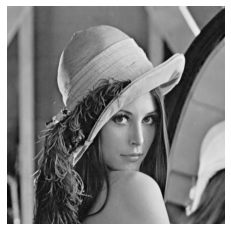

In [45]:
plt.imshow(RE_Y_Channel, cmap="gray")
plt.axis("off")
plt.show()

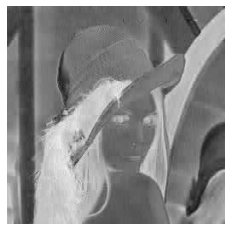

In [46]:
plt.imshow(RE_Cb_Channel,cmap="gray")
plt.axis("off")
plt.show()

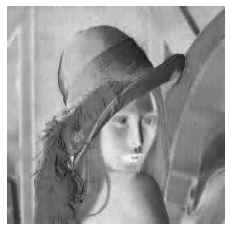

In [47]:
plt.imshow(RE_Cr_Channel, cmap="gray")
plt.axis("off")
plt.show()

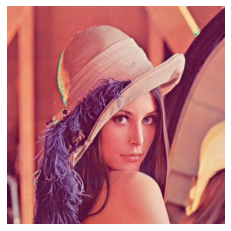

In [48]:
plt.imshow(RE_RGB)
plt.axis("off")
plt.show()